In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider

from tqdm import tqdm

In [2]:
#! pip install --upgrade matplotlib

(пункция фанка)

Рассмотрим рой из $N$ частиц. В $d$-мерном пространстве. Попытаемся смоделировать движение роя птиц.

Пусть каждая частица в каждый момент времени будет двигаться по вектору суммы:
- своего предыдущего вектора
- вектора в сторону центра роя
- вектора, параллельного среднему вектору скорости частиц
- вектора, параллельного среднему вектору близких к ней частиц (например, $k$ самых близких к ней частиц)

Тогда состояние системы задается тензором размера $S_t = Ten(N\times d\times 2)$. Где `S[i,:,0]` - вектор координат i-той частицы, а `S[i,:,1]` - вектор скорости i-той частицы в момент времени `t`.

In [2]:
def run_system(
    init_params,
    update_params,
    init_state,
    update_state,
    calc_logs,
    max_iters
):
    
    state = init_state(**init_params)
    log = []
    log.append(calc_logs(state))

    for i in tqdm(range(max_iters)):
        state = update_state(state, update_params)
        log.append(calc_logs(state))
    return state, log

In [4]:
a = np.ones((2, 2, 2))
a.sum(axis=0, keepdims=True).shape

(1, 2, 2)

In [3]:
def init_state(N, d):
    state = np.random.randn(N, d, 2) 
    return state

def update_state(state, update_params):
    state = update_coordinates(state, update_params)
    state = update_velocities(state, update_params)
    return state

def update_coordinates(state, update_params):
    time_rate = update_params["time_rate"]
    state[:,:,0] += state[:,:,1] * time_rate
    return state

def update_velocities(state, update_params):
    vel_prev_coef = update_params["vel_prev_coef"]
    vel_to_center_coef = update_params["vel_to_center_coef"]
    vel_average_coef = update_params["vel_average_coef"]
    
    vel_prev = state[:,:,1]
    swarm_center = state[:,:,0].mean(axis=0, keepdims=True)
    vel_to_center = swarm_center - state[:,:,0]
    vel_average = state[:,:,1].mean(axis=0, keepdims=True)
    state[:,:,1] = vel_prev * vel_prev_coef + vel_to_center * vel_to_center_coef + vel_average * vel_average_coef
    return state

def normalize_velocities(vel):
    return vel / np.sqrt((vel ** 2 + 1e-8).sum(axis=1,keepdims=True))

def calc_logs(state):
    return dict(
        state=np.copy(state),
    )

def plot_state(state):
    plt.quiver(*(state[:,:,0].T), *(state[:,:,1].T))
    plt.show()
    
def plot_dynamics(log, gif_filename='./animation.gif', fps=10):
    """
    Inspiration from
    https://towardsdatascience.com/intro-to-dynamic-visualization-with-python-animations-and-interactive-plots-f72a7fb69245
    """
    
    # Animation function
    def update_quiver(i, Q, ax, log):
        state = log[i]["state"]
        Q.set_offsets(state[:,:,0])
        Q.set_UVC(*(normalize_velocities(state[:,:,1]).T))

        ax.set_xlim(np.round(state[:,0,0].min(), -1) - 10, np.round(state[:,0,0].max(), -1) + 10)
        ax.set_ylim(np.round(state[:,1,0].min(), -1) - 10, np.round(state[:,1,0].max(), -1) + 10)
        return Q,

    # Create figure and add axes
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    ax.grid()
    state = log[0]["state"]
    Q = ax.quiver(*(state[:,:,0].T), *(state[:,:,1].T))

    anim = FuncAnimation(fig, update_quiver, fargs=(Q, ax, log), frames=max_iters,
                                   interval=10, blit=False)
    fig.tight_layout()
    #plt.show()

    anim.save(gif_filename, writer='imagemagick', fps=fps)

In [131]:
max_iters = 100
init_params = dict(N=10, d=2)
update_params = dict(time_rate=0.1,vel_prev_coef=0.2,vel_to_center_coef=0.1, vel_average_coef=0.8)
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 17314.66it/s]


MovieWriter imagemagick unavailable; using Pillow instead.


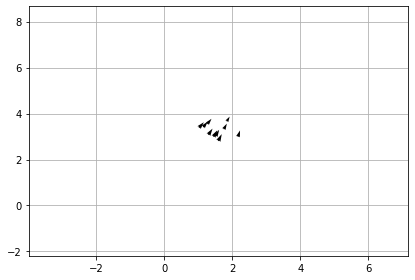

In [136]:
plot_dynamics(log)

In [4]:
# Plotting dynamics

# Animation function
def update_quiver(i, Q, ax, log):
    state = log[i]["state"]
    Q.set_offsets(state[:,:,0])
    Q.set_UVC(*(state[:,:,1].T))
    
    ax.set_xlim(np.round(state[:,0,0].min(), -1) - 15, np.round(state[:,0,0].max(), -1) + 15)
    ax.set_ylim(np.round(state[:,1,0].min(), -1) - 15, np.round(state[:,1,0].max(), -1) + 15)
    return Q,

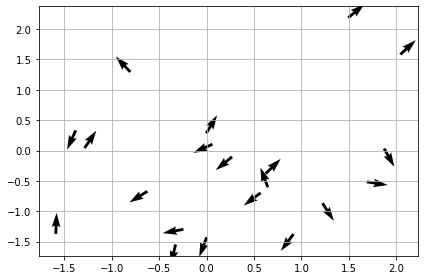

MovieWriter imagemagick unavailable; using Pillow instead.


In [66]:
# Create figure and add axes
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()
state = log[0]["state"]
Q = ax.quiver(*(state[:,:,0].T), *(state[:,:,1].T))

anim = FuncAnimation(fig, update_quiver, fargs=(Q, ax, log), frames=max_iters,
                               interval=10, blit=False)
fig.tight_layout()
plt.show()

anim.save('./gifs/nonlocal-velocity-update.gif', writer='imagemagick', fps=10)

Ну что ж, как мы выяснили, без учета локальности самоорганизации не возникает. В целом, оно и неудивительно. Значит, в следующих сериях надо бы и это учесть.

Я рад, что научился анимировать динамику. Это будет мне полезно.

### Добавить локальность в динамику
Мне кажется, оптимальным будет добавить такую динамику:
- Выбрать случайную перестановку индексов частиц. Так у каждой частица будет своя. И если выбранная достаточно к ней близка (например, ближе чем центр роя), то поменять вектор в её сторону и в сторону её вектора.

In [25]:
def normalize_velocities(vel):
    return vel / np.sqrt((vel ** 2 + 1e-8).sum(axis=1,keepdims=True))

def normalize_velocity(vel):
    return vel / np.sqrt((vel ** 2 + 1e-8).sum())

def update_velocities(state, update_params):
    vel_prev_coef = update_params["vel_prev_coef"]
    vel_to_center_coef = update_params["vel_to_center_coef"]
    vel_average_coef = update_params["vel_average_coef"]
    vel_of_local_rand_coef = update_params["vel_of_local_rand_coef"]
    
    vel_prev = state[:,:,1]
    swarm_center = state[:,:,0].mean(axis=0, keepdims=True)
    vel_to_center = swarm_center - state[:,:,0]
    vel_average = state[:,:,1].mean(axis=0, keepdims=True)
    
    N = state.shape[0]
    pertrub_state = state[np.random.choice(N, N)]
    dist_to_rand_particle = ((pertrub_state[:,:,0] - state[:,:,0]) ** 2).sum(axis=1)
    dist_to_swarm_center_particle = ((swarm_center - state[:,:,0]) ** 2).sum(axis=1)
    vel_of_local_rand = pertrub_state[:,:,1] * (dist_to_rand_particle < dist_to_swarm_center_particle).reshape(-1,1)
    
    state[:,:,1] = 0
    state[:,:,1] += normalize_velocities(vel_prev) * vel_prev_coef
    state[:,:,1] += normalize_velocities(vel_to_center) * vel_to_center_coef
    state[:,:,1] += normalize_velocities(vel_average) * vel_average_coef
    state[:,:,1] += normalize_velocities(vel_of_local_rand) * vel_of_local_rand_coef
    state[:,:,1] = normalize_velocities(state[:,:,1])
    
    return state

In [5]:
max_iters = 100
init_params = dict(N=20, d=2)
update_params = dict(
    time_rate=0.1,
    vel_prev_coef=1,vel_to_center_coef=0, vel_average_coef=1,vel_of_local_rand_coef=3)
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 3699.86it/s]


MovieWriter imagemagick unavailable; using Pillow instead.


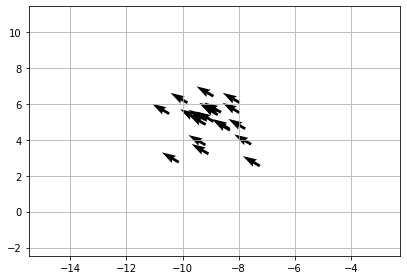

In [6]:
plot_dynamics(log, './gifs/introduce-local-dynamics.gif', fps=10)

Без случайного шума в скоростях получается как-то не очень. А жаль, ведь в игре Жизнь нет никакого шума.

Заменим копирование вектора близкой частицы на поворот в сторону близкой частицы.

In [6]:
def update_velocities(state, update_params):
    vel_prev_coef = update_params["vel_prev_coef"]
    vel_to_center_coef = update_params["vel_to_center_coef"]
    vel_average_coef = update_params["vel_average_coef"]
    vel_of_local_rand_coef = update_params["vel_of_local_rand_coef"]
    vel_to_local_rand_coef = update_params["vel_to_local_rand_coef"]
    
    vel_prev = state[:,:,1]
    swarm_center = state[:,:,0].mean(axis=0, keepdims=True)
    vel_to_center = swarm_center - state[:,:,0]
    vel_average = state[:,:,1].mean(axis=0, keepdims=True)
    
    N = state.shape[0]
    pertrub_state = state[np.random.choice(N, N)]
    dist_to_rand_particle = ((pertrub_state[:,:,0] - state[:,:,0]) ** 2).sum(axis=1)
    dist_to_swarm_center_particle = ((swarm_center - state[:,:,0]) ** 2).sum(axis=1)
    vel_of_local_rand = pertrub_state[:,:,1] * (dist_to_rand_particle < dist_to_swarm_center_particle).reshape(-1,1)
    vel_to_local_rand = (pertrub_state[:,:,0] - state[:,:,0]) * (dist_to_rand_particle < 1.4 * dist_to_swarm_center_particle).reshape(-1,1)
    
    state[:,:,1] = 0
    state[:,:,1] += normalize_velocities(vel_prev) * vel_prev_coef
    state[:,:,1] += normalize_velocities(vel_to_center) * vel_to_center_coef
    state[:,:,1] += normalize_velocities(vel_average) * vel_average_coef
    state[:,:,1] += normalize_velocities(vel_of_local_rand) * vel_of_local_rand_coef
    state[:,:,1] += normalize_velocities(vel_to_local_rand) * vel_to_local_rand_coef
    # state[:,:,1] = normalize_velocities(state[:,:,1])
    
    return state

In [84]:
random_sample_size = 1
N = 20
d = 2
random_particles = state[np.random.choice(N, random_sample_size * N)]
random_particles.shape, state.shape

((20, 2, 2), (20, 2, 2))

In [85]:
random_particles.reshape(N, random_sample_size, d, 2).transpose(0, 2, 3, 1).shape

(20, 2, 2, 1)

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 3571.60it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


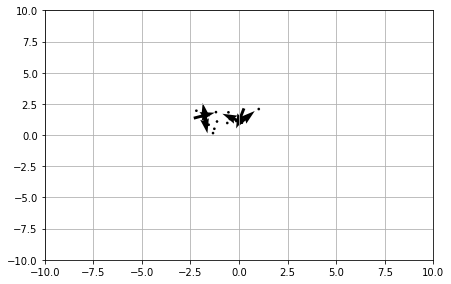

In [86]:
max_iters = 100
init_params = dict(N=20, d=2)
update_params = dict(
    time_rate=0.2,
    vel_prev_coef=1,vel_to_center_coef=0, vel_average_coef=0,vel_of_local_rand_coef=0, vel_to_local_rand_coef=10)
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/introduce-local-dynamics-v2.gif', fps=20)

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 13329.64it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


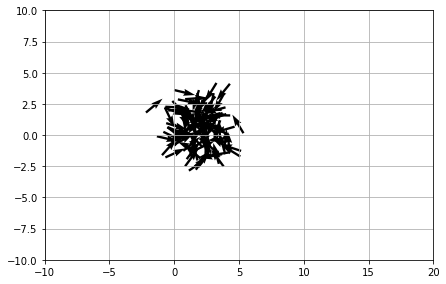

In [100]:
def init_state(N, d):
    state = np.random.randn(N, d, 2) 
    state[:,:,1] = normalize_velocities(state[:,:,1])
    return state


max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    time_rate=0.2,
    vel_prev_coef=1,vel_to_center_coef=0.01, vel_average_coef=0,vel_of_local_rand_coef=0, vel_to_local_rand_coef=0.0)
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/introduce-local-dynamics-v5.gif', fps=15)

Еееее, что-то получилось :)

In [65]:
np.round(11, -1) + 10

20

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 4438.42it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


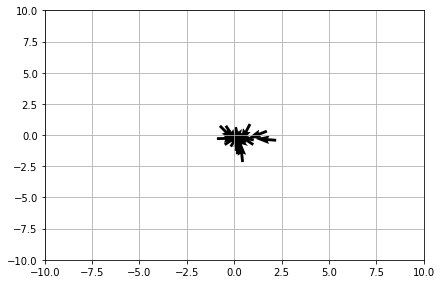

In [95]:
def update_velocities_(state, update_params):
    vel_prev_coef = update_params["vel_prev_coef"]
    vel_to_center_coef = update_params["vel_to_center_coef"]
    vel_average_coef = update_params["vel_average_coef"]
    vel_of_local_rand_coef = update_params["vel_of_local_rand_coef"]
    vel_to_local_rand_coef = update_params["vel_to_local_rand_coef"]
    
    vel_prev = state[:,:,1]
    swarm_center = state[:,:,0].mean(axis=0, keepdims=True)
    vel_to_center = swarm_center - state[:,:,0]
    vel_average = state[:,:,1].mean(axis=0, keepdims=True)
    
    N = state.shape[0]
    pertrub_state = state[np.random.choice(N, N)]
    dist_to_rand_particle = ((pertrub_state[:,:,0] - state[:,:,0]) ** 2).sum(axis=1)
    dist_to_swarm_center_particle = ((swarm_center - state[:,:,0]) ** 2).sum(axis=1)
    vel_of_local_rand = pertrub_state[:,:,1] * (dist_to_rand_particle < dist_to_swarm_center_particle).reshape(-1,1)
    vel_to_local_rand = (pertrub_state[:,:,0] - state[:,:,0]) * (dist_to_rand_particle < 2).reshape(-1,1)
    
    state[:,:,1] = 0
    state[:,:,1] += normalize_velocities(vel_prev) * vel_prev_coef
    state[:,:,1] += normalize_velocities(vel_to_center) * vel_to_center_coef
    state[:,:,1] += normalize_velocities(vel_average) * vel_average_coef
    state[:,:,1] += normalize_velocities(vel_of_local_rand) * vel_of_local_rand_coef
    state[:,:,1] += normalize_velocities(vel_to_local_rand) * vel_to_local_rand_coef
    # state[:,:,1] = normalize_velocities(state[:,:,1])    
    return state


max_iters = 100
init_params = dict(N=20, d=2)
update_params = dict(
    time_rate=0.2,
    vel_prev_coef=1,vel_to_center_coef=0.01, vel_average_coef=0,
    vel_of_local_rand_coef=0, vel_to_local_rand_coef=0.0)

state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/introduce-local-dynamics-v4.gif', fps=15)

Чтобы улучшить модель, надо в расчете скростей использовать cross join. Без него дальше никак.

Кажется, надо отказаться от векторизованных расчетов и перейти к поштучным.

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 3019.37it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


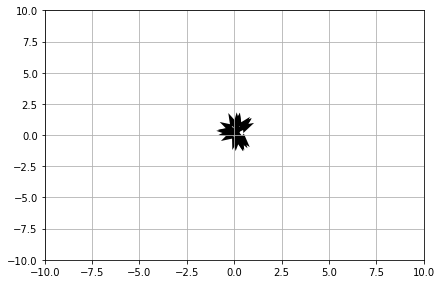

In [8]:
def init_state(N, d):
    state = np.random.randn(N, d, 2) 
    state[:,:,1] = normalize_velocities(state[:,:,1])
    return state

def update_velocities_(state, update_params):
    vel_prev_coef = update_params["vel_prev_coef"]
    vel_to_center_coef = update_params["vel_to_center_coef"]
    vel_average_coef = update_params["vel_average_coef"]
    vel_of_local_rand_coef = update_params["vel_of_local_rand_coef"]
    vel_to_local_rand_coef = update_params["vel_to_local_rand_coef"]
    
    vel_prev = state[:,:,1]
    swarm_center = state[:,:,0].mean(axis=0, keepdims=True)
    vel_to_center = swarm_center - state[:,:,0]
    vel_average = state[:,:,1].mean(axis=0, keepdims=True)
    
    N = state.shape[0]
    pertrub_state = state[np.random.choice(N, N)]
    dist_to_rand_particle = ((pertrub_state[:,:,0] - state[:,:,0]) ** 2).sum(axis=1)
    dist_to_swarm_center_particle = ((swarm_center - state[:,:,0]) ** 2).sum(axis=1)
    vel_of_local_rand = pertrub_state[:,:,1] * (dist_to_rand_particle < dist_to_swarm_center_particle).reshape(-1,1)
    vel_to_local_rand = (pertrub_state[:,:,0] - state[:,:,0]) * (dist_to_rand_particle < 2).reshape(-1,1)
    
    state[:,:,1] = 0
    state[:,:,1] += normalize_velocities(vel_prev) * vel_prev_coef
    state[:,:,1] += normalize_velocities(vel_to_center) * vel_to_center_coef
    state[:,:,1] += normalize_velocities(vel_average) * vel_average_coef
    state[:,:,1] += normalize_velocities(vel_of_local_rand) * vel_of_local_rand_coef
    state[:,:,1] += normalize_velocities(vel_to_local_rand) * vel_to_local_rand_coef
    # state[:,:,1] = normalize_velocities(state[:,:,1])    
    return state


max_iters = 100
init_params = dict(N=20, d=2)
update_params = dict(
    time_rate=0.2,
    vel_prev_coef=1,vel_to_center_coef=0.01, vel_average_coef=0,
    vel_of_local_rand_coef=0, vel_to_local_rand_coef=0.0)

state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/introduce-local-dynamics-v4.gif', fps=15)

### Уходим от чистой векторизации

Это нужно, чтобы легко было учесть локальность в потоках.

Для начала правила возьмём из вики:
1. Избегаем столкновений (т.е. добавляем антивектор в сторону от частиц в непосредственной близости)
2. Синхронизируем направление скоростей с ближайшими частицами (т.е. добавляем средний вектор частиц в окрестности)
3. Движемся в сторону центра всего роя (вектор в сторону центра всего роя)

In [8]:
init_state(100, 2).shape

(100, 2, 2)

In [24]:
normalize_velocities

<function __main__.normalize_velocities(vel)>

In [48]:
def update_velocities_boid(state, update_params=dict()):
    """
    Input:
        state: Tensor N x d x 2, where state[:,:,0] are coordinates, state[:,:,1] are velocities
        update_params: dict, with params for function updating velocities
    Return:
        state: Tensor N x d x 2 with updated velocities
    """
    collisions_distance = update_params["collisions_distance"]
    sync_distance = update_params["sync_distance"]
    clustering_distance = update_params["clustering_distance"]
    
    prev_coef = update_params["prev_coef"]
    collisions_coef = update_params["collisions_coef"]
    sync_coef = update_params["sync_coef"]
    clustering_coef = update_params["clustering_coef"]
    
    time_rate = update_params["time_rate"]
    for i, particle in enumerate(state):
        avoid_collisions = -vector_to_local_particles(particle, state, collisions_distance)
        avoid_collisions = normalize_velocity(avoid_collisions)
        
        sync_local_velocities = vector_like_local_velocities(particle, state, sync_distance)
        sync_local_velocities = normalize_velocity(sync_local_velocities)
        
        to_local_center = vector_to_local_particles(particle, state, clustering_distance)
        to_local_center = normalize_velocity(to_local_center)
        
        prev_velocity = normalize_velocity(state[i,:,1])
        
        state[i,:,1] = 0
        state[i,:,1] += prev_coef * prev_velocity
        state[i,:,1] += collisions_coef * avoid_collisions
        state[i,:,1] += sync_coef * sync_local_velocities
        state[i,:,1] += clustering_coef * to_local_center
    return state


def vector_to_local_particles(particle, state, distance):
    N, d, _ = state.shape
    distances = np.sqrt(np.sum((particle[:,0].reshape(1, -1) - state[:,:,0]) ** 2, axis=1))
    assert state.shape[0] == distances.shape[0]
    local_particles = state[distances < distance][:,:,0]
    assert local_particles.shape[1] == d
    return local_particles.mean(axis=0) - particle[:,0]


def vector_like_local_velocities(particle, state, distance):
    distances = np.sqrt(np.sum((particle[:,0].reshape(1, -1) - state[:,:,0]) ** 2, axis=1))
    local_velocities = state[distances < distance][:,:,1]
    return local_velocities.mean(axis=0)

In [36]:
update_params = dict(
    collisions_distance = 0.5,
    sync_distance = 2,
    clustering_distance = 5,
    collisions_coef = 1.,
    sync_coef = 1,
    clustering_coef = 1,
    time_rate = 0.1,
)
update_velocities_boid(init_state(100, 2), update_params)

array([[[-4.32339712e-01,  8.10872973e-01],
        [ 8.80413226e-01, -1.26926191e+00]],

       [[ 8.38160588e-01, -6.45829758e-01],
        [-1.45155991e+00,  1.00919140e+00]],

       [[-1.69211804e-01,  1.11017036e-01],
        [-8.93928027e-01,  1.44325312e+00]],

       [[-1.69182158e+00,  1.18324973e-01],
        [ 5.14372498e-01, -1.36094154e+00]],

       [[-3.92233675e-02, -1.64335540e-01],
        [-7.56741585e-01,  2.48185308e+00]],

       [[-1.35026071e+00,  4.38728695e-01],
        [ 1.42536145e+00, -1.81958666e+00]],

       [[ 1.27856909e+00, -2.16266999e-01],
        [ 9.81877331e-01, -1.07439030e+00]],

       [[ 9.52390106e-01,  5.45899102e-01],
        [-6.71989379e-01,  1.09602115e+00]],

       [[-6.08696268e-01,  1.38796646e+00],
        [ 9.74759767e-01, -2.14752719e+00]],

       [[-1.11277619e+00,  1.06620117e+00],
        [-1.08796062e+00,  4.25929562e-01]],

       [[ 4.92940792e-01, -1.67745514e+00],
        [-1.83620278e-02,  6.30634969e-01]],

       [[ 

100%|████████████████████████████████████████| 100/100 [00:02<00:00, 36.08it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


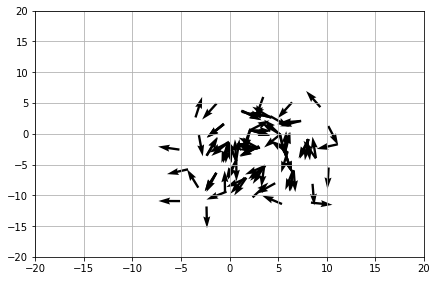

In [44]:
max_iters = 100
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 4,
    clustering_distance = 5,
    collisions_coef = 2.,
    sync_coef = 1,
    clustering_coef = 1,
    time_rate = 0.1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v1.gif', fps=15)

100%|████████████████████████████████████████| 100/100 [00:02<00:00, 36.95it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


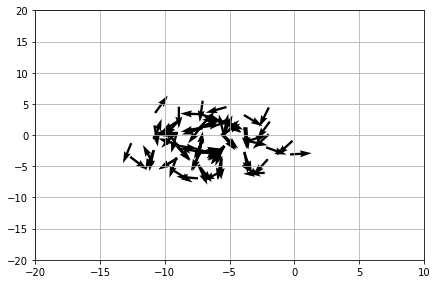

In [45]:
max_iters = 100
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 2,
    sync_distance = 4,
    clustering_distance = 5,
    collisions_coef = 2.,
    sync_coef = 1,
    clustering_coef = 1,
    time_rate = 0.1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v2.gif', fps=15)

100%|████████████████████████████████████████| 300/300 [00:07<00:00, 38.83it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


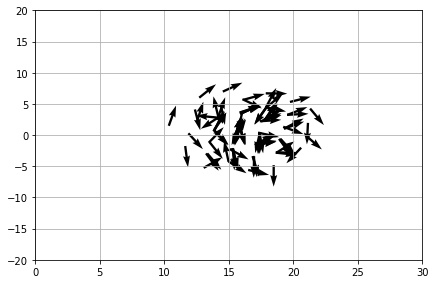

In [46]:
max_iters = 300
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 2,
    sync_distance = 4,
    clustering_distance = 5,
    collisions_coef = 2.,
    sync_coef = 1,
    clustering_coef = 1,
    time_rate = 0.1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v2.gif', fps=10)

100%|████████████████████████████████████████| 200/200 [00:05<00:00, 36.57it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


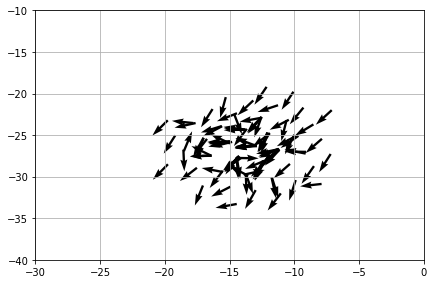

In [52]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 2,
    sync_distance = 4,
    clustering_distance = 5,
    collisions_coef = 2.,
    sync_coef = 1,
    clustering_coef = 1,
    prev_coef = 1,
    time_rate = 0.1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v3.gif', fps=5)

100%|████████████████████████████████████████| 200/200 [00:05<00:00, 41.12it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


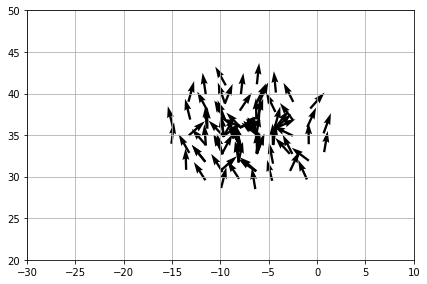

In [57]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 2,
    sync_distance = 4,
    clustering_distance = 7,
    collisions_coef = 1.5,
    sync_coef = 1,
    clustering_coef = 0.5,
    prev_coef = 1,
    time_rate = 0.1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v4.gif', fps=7)

100%|████████████████████████████████████████| 200/200 [00:05<00:00, 37.54it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


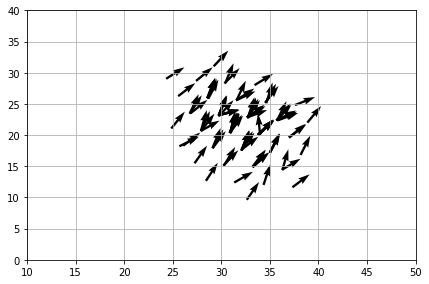

In [58]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 4,
    clustering_distance = 7,
    collisions_coef = 1.,
    sync_coef = 1,
    clustering_coef = 0.5,
    prev_coef = 1,
    time_rate = 0.1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v5.gif', fps=7)

100%|████████████████████████████████████████| 200/200 [00:06<00:00, 32.77it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


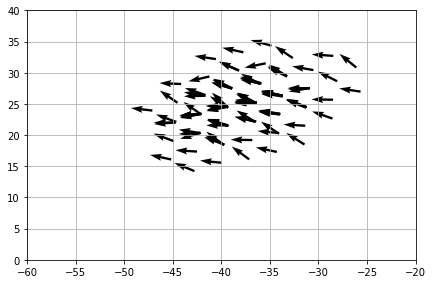

In [61]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 4,
    clustering_distance = 7,
    collisions_coef = 1.,
    sync_coef = 1,
    clustering_coef = 0.5,
    prev_coef = 1.5,
    time_rate = 0.1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v6.gif', fps=7)

100%|████████████████████████████████████████| 200/200 [00:04<00:00, 40.77it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


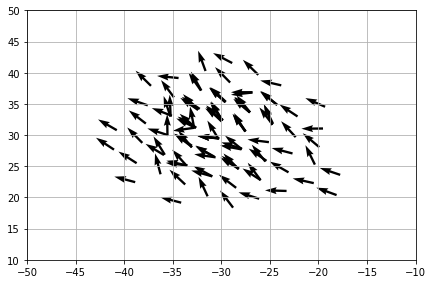

In [62]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 4,
    clustering_distance = 7,
    collisions_coef = 1.5,
    sync_coef = 1,
    clustering_coef = 0.5,
    prev_coef = 1.5,
    time_rate = 0.1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v7.gif', fps=7)

In [68]:
def init_state(N, d):
    print("Initializing state")
    return np.random.rand(N, d, 2) * 100

Initializing state


100%|████████████████████████████████████████| 200/200 [00:04<00:00, 41.91it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


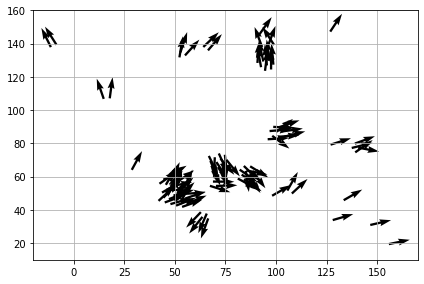

In [69]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 4,
    clustering_distance = 7,
    collisions_coef = 1.5,
    sync_coef = 1,
    clustering_coef = 0.5,
    prev_coef = 1.5,
    time_rate = 0.1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v8.gif', fps=7)

Initializing state


100%|████████████████████████████████████████| 200/200 [00:05<00:00, 39.72it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


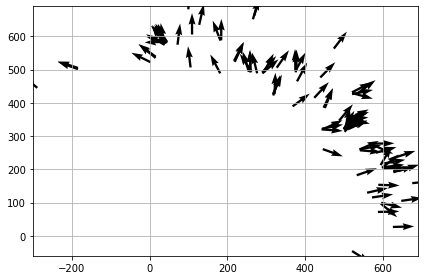

In [71]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 4,
    clustering_distance = 7,
    collisions_coef = 1.5,
    sync_coef = 1,
    clustering_coef = 0.5,
    prev_coef = 1.5,
    time_rate = 1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v9.gif', fps=7)

In [84]:
def init_state(N, d):
    coords = np.random.rand(N, d) * 100
    velocities = np.random.randn(N, d) * 2
    return np.stack((coords, velocities), axis=2)

100%|████████████████████████████████████████| 200/200 [00:04<00:00, 41.30it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


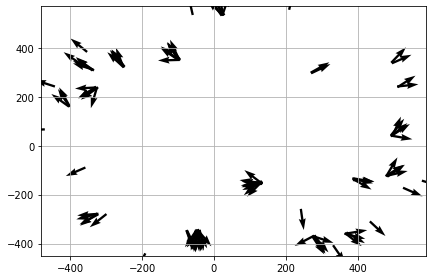

In [87]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 4,
    clustering_distance = 7,
    collisions_coef = 1.5,
    sync_coef = 1,
    clustering_coef = 1,
    prev_coef = 1.5,
    time_rate = 1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v10.gif', fps=7)

100%|████████████████████████████████████████| 200/200 [00:04<00:00, 42.81it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


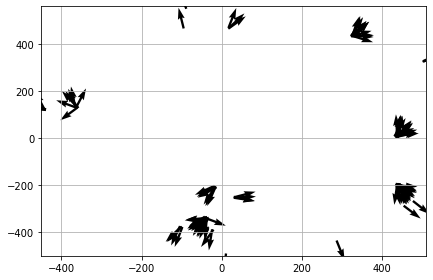

In [89]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 4,
    clustering_distance = 10,
    collisions_coef = 1.5,
    sync_coef = 1,
    clustering_coef = 1,
    prev_coef = 1.5,
    time_rate = 1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v11.gif', fps=7)

100%|████████████████████████████████████████| 200/200 [00:04<00:00, 40.35it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


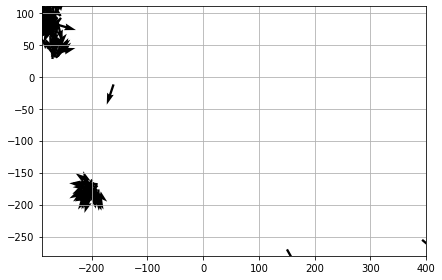

In [90]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 20,
    collisions_coef = 2.,
    sync_coef = 1,
    clustering_coef = 1,
    prev_coef = 1.5,
    time_rate = 1,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v12.gif', fps=7)

100%|████████████████████████████████████████| 200/200 [00:05<00:00, 34.36it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


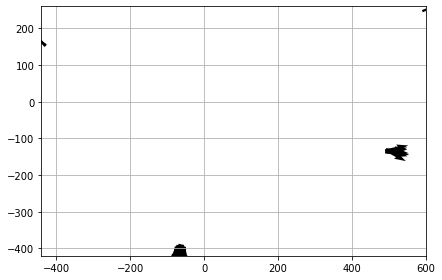

In [92]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 20,
    collisions_coef = 2.,
    sync_coef = 3,
    clustering_coef = 1,
    prev_coef = 1.5,
    time_rate =0.6,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v13.gif', fps=7)

In [94]:
def update_velocities_boid(state, update_params=dict()):
    """
    Input:
        state: Tensor N x d x 2, where state[:,:,0] are coordinates, state[:,:,1] are velocities
        update_params: dict, with params for function updating velocities
    Return:
        state: Tensor N x d x 2 with updated velocities
    """
    collisions_distance = update_params["collisions_distance"]
    sync_distance = update_params["sync_distance"]
    clustering_distance = update_params["clustering_distance"]
    global_distance = update_params["global_distance"]
    
    prev_coef = update_params["prev_coef"]
    collisions_coef = update_params["collisions_coef"]
    sync_coef = update_params["sync_coef"]
    clustering_coef = update_params["clustering_coef"]
    global_coef = update_params["global_coef"]
    
    time_rate = update_params["time_rate"]
    for i, particle in enumerate(state):
        avoid_collisions = -vector_to_local_particles(particle, state, collisions_distance)
        avoid_collisions = normalize_velocity(avoid_collisions)
        
        sync_local_velocities = vector_like_local_velocities(particle, state, sync_distance)
        sync_local_velocities = normalize_velocity(sync_local_velocities)
        
        to_local_center = vector_to_local_particles(particle, state, clustering_distance)
        to_local_center = normalize_velocity(to_local_center)
        
        to_global_center = vector_to_local_particles(particle, state, global_distance)
        to_global_center = normalize_velocity(to_global_center)
        
        prev_velocity = normalize_velocity(state[i,:,1])
        
        state[i,:,1] = 0
        state[i,:,1] += prev_coef * prev_velocity
        state[i,:,1] += collisions_coef * avoid_collisions
        state[i,:,1] += sync_coef * sync_local_velocities
        state[i,:,1] += clustering_coef * to_local_center
        state[i,:,1] += global_coef * to_global_center
    return state

100%|████████████████████████████████████████| 200/200 [00:06<00:00, 29.23it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


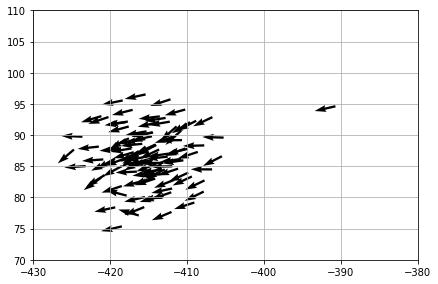

In [95]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 15,
    global_distance = 1000,
    collisions_coef = 2.,
    sync_coef = 3,
    clustering_coef = 1,
    global_coef = 0.5,
    prev_coef = 1.5,
    time_rate = 0.6,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v14.gif', fps=7)

е-е-е-е-е-е!!!
yeahh!

(very happy right know)

100%|████████████████████████████████████████| 200/200 [00:06<00:00, 32.75it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


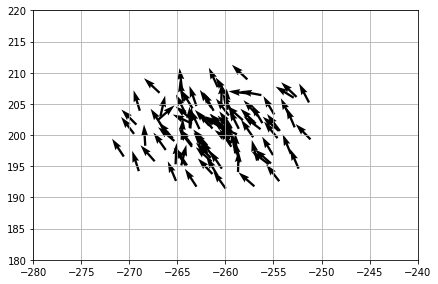

In [96]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 15,
    global_distance = 1000,
    collisions_coef = 2.,
    sync_coef = 2,
    clustering_coef = 1,
    global_coef = 0.5,
    prev_coef = 1.5,
    time_rate = 0.6,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v15.gif', fps=7)



  0%|                                                  | 0/200 [00:00<?, ?it/s]

  2%|▋                                         | 3/200 [00:00<00:07, 25.87it/s]

  4%|█▍                                        | 7/200 [00:00<00:06, 27.63it/s]

  5%|██                                       | 10/200 [00:00<00:07, 26.47it/s]

  6%|██▋                                      | 13/200 [00:00<00:07, 26.33it/s]

  8%|███▍                                     | 17/200 [00:00<00:06, 26.79it/s]

 10%|████                                     | 20/200 [00:00<00:07, 24.81it/s]

 12%|████▋                                    | 23/200 [00:00<00:07, 24.13it/s]

 13%|█████▎                                   | 26/200 [00:00<00:06, 25.58it/s]

 14%|█████▉                                   | 29/200 [00:01<00:06, 26.18it/s]

 16%|██████▊                                  | 33/200 [00:01<00:06, 27.50it/s]

 18%|███████▌                                 | 37/200 [00:01<00:05, 28.95it/s]

 20%|████████▏            

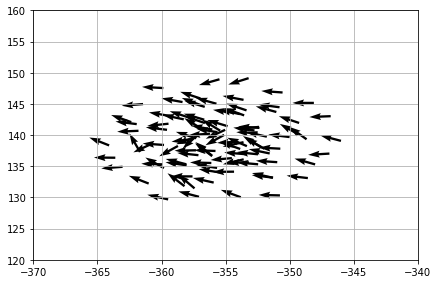

In [99]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 15,
    global_distance = 1000,
    collisions_coef = 2.,
    sync_coef = 2,
    clustering_coef = 1,
    global_coef = 0.5,
    prev_coef = 2.,
    time_rate = 0.6,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v16.gif', fps=7)



  0%|                                                  | 0/200 [00:00<?, ?it/s]

  2%|▊                                         | 4/200 [00:00<00:04, 39.73it/s]

  4%|█▋                                        | 8/200 [00:00<00:04, 38.81it/s]

  6%|██▍                                      | 12/200 [00:00<00:05, 37.37it/s]

  8%|███▎                                     | 16/200 [00:00<00:05, 36.40it/s]

 10%|████                                     | 20/200 [00:00<00:05, 35.63it/s]

 12%|████▉                                    | 24/200 [00:00<00:04, 35.96it/s]

 14%|█████▋                                   | 28/200 [00:00<00:04, 34.82it/s]

 16%|██████▌                                  | 32/200 [00:00<00:04, 34.67it/s]

 18%|███████▍                                 | 36/200 [00:01<00:04, 36.04it/s]

 20%|████████▍                                | 41/200 [00:01<00:04, 37.94it/s]

 22%|█████████▏                               | 45/200 [00:01<00:04, 36.77it/s]

 24%|██████████           

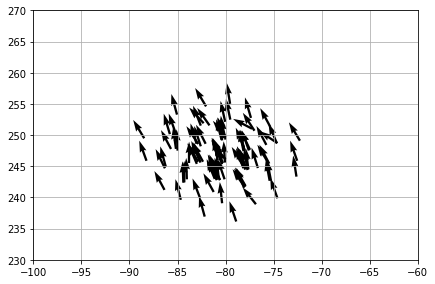

In [101]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 15,
    global_distance = 1000,
    collisions_coef = 1.,
    sync_coef = 1,
    clustering_coef = 0.5,
    global_coef = 0.25,
    prev_coef = 1.5,
    time_rate = 0.6,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v17.gif', fps=7)



  0%|                                                  | 0/200 [00:00<?, ?it/s]

  2%|▋                                         | 3/200 [00:00<00:07, 27.08it/s]

  4%|█▍                                        | 7/200 [00:00<00:06, 28.33it/s]

  6%|██▎                                      | 11/200 [00:00<00:06, 29.92it/s]

  8%|███                                      | 15/200 [00:00<00:06, 29.91it/s]

 10%|███▉                                     | 19/200 [00:00<00:05, 32.08it/s]

 12%|████▋                                    | 23/200 [00:00<00:05, 32.63it/s]

 14%|█████▌                                   | 27/200 [00:00<00:05, 32.54it/s]

 16%|██████▎                                  | 31/200 [00:00<00:05, 31.21it/s]

 17%|██████▉                                  | 34/200 [00:01<00:05, 30.41it/s]

 19%|███████▊                                 | 38/200 [00:01<00:05, 32.17it/s]

 21%|████████▌                                | 42/200 [00:01<00:04, 34.12it/s]

 23%|█████████▍           

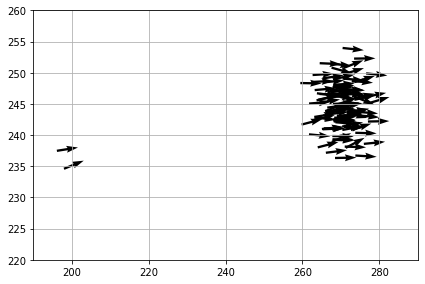

In [102]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 15,
    global_distance = 1000,
    collisions_coef = 1.,
    sync_coef = 1,
    clustering_coef = 0.5,
    global_coef = 0.25,
    prev_coef = 2.5,
    time_rate = 0.6,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v18.gif', fps=7)



  0%|                                                  | 0/200 [00:00<?, ?it/s]

  2%|█                                         | 5/200 [00:00<00:04, 40.14it/s]

  4%|█▉                                        | 9/200 [00:00<00:04, 39.09it/s]

  6%|██▍                                      | 12/200 [00:00<00:05, 35.76it/s]

  8%|███                                      | 15/200 [00:00<00:05, 32.58it/s]

 10%|███▉                                     | 19/200 [00:00<00:05, 34.05it/s]

 12%|████▋                                    | 23/200 [00:00<00:04, 35.64it/s]

 14%|█████▌                                   | 27/200 [00:00<00:04, 35.89it/s]

 16%|██████▎                                  | 31/200 [00:00<00:04, 36.34it/s]

 18%|███████▏                                 | 35/200 [00:01<00:04, 33.54it/s]

 20%|███████▉                                 | 39/200 [00:01<00:04, 35.09it/s]

 22%|████████▊                                | 43/200 [00:01<00:05, 30.28it/s]

 24%|█████████▋           

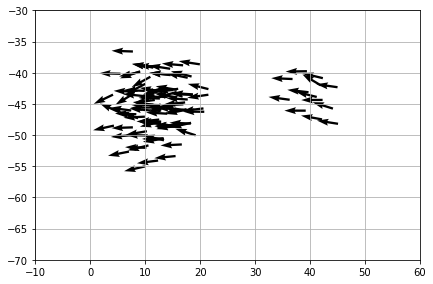

In [104]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 15,
    global_distance = 1000,
    collisions_coef = 1.,
    sync_coef = 0.7,
    clustering_coef = 0.5,
    global_coef = 0.25,
    prev_coef = 2.5,
    time_rate = 0.6,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v19.gif', fps=7)



  0%|                                                  | 0/200 [00:00<?, ?it/s]

  2%|█                                         | 5/200 [00:00<00:04, 44.38it/s]

  4%|█▉                                        | 9/200 [00:00<00:04, 41.80it/s]

  6%|██▋                                      | 13/200 [00:00<00:04, 38.13it/s]

  8%|███▍                                     | 17/200 [00:00<00:04, 38.33it/s]

 11%|████▌                                    | 22/200 [00:00<00:04, 40.15it/s]

 13%|█████▎                                   | 26/200 [00:00<00:04, 35.42it/s]

 15%|██████▏                                  | 30/200 [00:00<00:04, 35.93it/s]

 17%|██████▉                                  | 34/200 [00:00<00:05, 33.03it/s]

 19%|███████▊                                 | 38/200 [00:01<00:04, 33.52it/s]

 21%|████████▌                                | 42/200 [00:01<00:04, 35.22it/s]

 23%|█████████▍                               | 46/200 [00:01<00:04, 33.75it/s]

 25%|██████████▎          

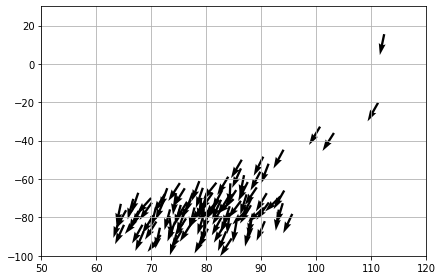

In [105]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 15,
    global_distance = 1000,
    collisions_coef = 1.,
    sync_coef = 0.7,
    clustering_coef = 0.,
    global_coef = 0.25,
    prev_coef = 2.5,
    time_rate = 0.6,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v20.gif', fps=7)



  0%|                                                  | 0/200 [00:00<?, ?it/s]

  2%|▊                                         | 4/200 [00:00<00:06, 29.66it/s]

  4%|█▍                                        | 7/200 [00:00<00:06, 29.40it/s]

  6%|██▎                                      | 11/200 [00:00<00:06, 30.94it/s]

  8%|███                                      | 15/200 [00:00<00:05, 31.26it/s]

 10%|███▉                                     | 19/200 [00:00<00:05, 33.24it/s]

 12%|████▋                                    | 23/200 [00:00<00:05, 32.11it/s]

 13%|█████▎                                   | 26/200 [00:00<00:06, 26.01it/s]

 14%|█████▉                                   | 29/200 [00:00<00:06, 27.06it/s]

 16%|██████▊                                  | 33/200 [00:01<00:05, 28.30it/s]

 18%|███████▌                                 | 37/200 [00:01<00:05, 29.16it/s]

 20%|████████▏                                | 40/200 [00:01<00:05, 28.12it/s]

 22%|████████▊            

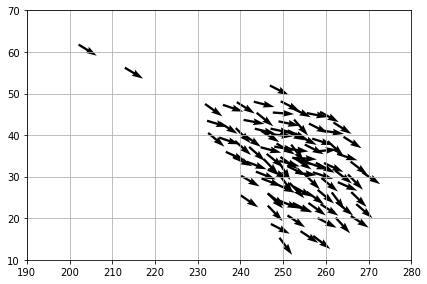

In [106]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 15,
    global_distance = 1000,
    collisions_coef = 1.,
    sync_coef = 0.5,
    clustering_coef = 0.,
    global_coef = 0.25,
    prev_coef = 2.5,
    time_rate = 0.6,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v21.gif', fps=7)

**Проблема**
- в долгросрочной перспективе частицы синхронизируются в один или несколько кластеров и движутся все в одном направлении

**Чего хочется?**
- Чтобы частицы формировали много кластеров, которые бы двигались отчасти независимо, по непрямым траекториям, и иногда могли сливаться или разделяться. И чтобы при этом мат модель была максимально простой

**Что делать?**
- добавить избегание локальных скоплений (если в окрестности слишком много частиц, то бежать от них)
- двигаться в сторону нуля

**В сторону нуля**

In [107]:
def update_velocities_boid(state, update_params=dict()):
    """
    Input:
        state: Tensor N x d x 2, where state[:,:,0] are coordinates, state[:,:,1] are velocities
        update_params: dict, with params for function updating velocities
    Return:
        state: Tensor N x d x 2 with updated velocities
    """
    collisions_distance = update_params["collisions_distance"]
    sync_distance = update_params["sync_distance"]
    clustering_distance = update_params["clustering_distance"]
    global_distance = update_params["global_distance"]
    
    prev_coef = update_params["prev_coef"]
    collisions_coef = update_params["collisions_coef"]
    sync_coef = update_params["sync_coef"]
    clustering_coef = update_params["clustering_coef"]
    global_coef = update_params["global_coef"]
    to_zero_coef = update_params["to_zero_coef"]
    
    time_rate = update_params["time_rate"]
    for i, particle in enumerate(state):
        avoid_collisions = -vector_to_local_particles(particle, state, collisions_distance)
        avoid_collisions = normalize_velocity(avoid_collisions)
        
        sync_local_velocities = vector_like_local_velocities(particle, state, sync_distance)
        sync_local_velocities = normalize_velocity(sync_local_velocities)
        
        to_local_center = vector_to_local_particles(particle, state, clustering_distance)
        to_local_center = normalize_velocity(to_local_center)
        
        to_global_center = vector_to_local_particles(particle, state, global_distance)
        to_global_center = normalize_velocity(to_global_center)
        
        to_zero = -normalize_velocity(state[i,:,0])
        
        prev_velocity = normalize_velocity(state[i,:,1])
        
        state[i,:,1] = 0
        state[i,:,1] += prev_coef * prev_velocity
        state[i,:,1] += to_zero_coef * to_zero
        state[i,:,1] += collisions_coef * avoid_collisions
        state[i,:,1] += sync_coef * sync_local_velocities
        state[i,:,1] += clustering_coef * to_local_center
        state[i,:,1] += global_coef * to_global_center
    return state



  0%|                                                  | 0/200 [00:00<?, ?it/s]

  2%|▊                                         | 4/200 [00:00<00:05, 36.79it/s]

  4%|█▋                                        | 8/200 [00:00<00:05, 37.59it/s]

  6%|██▍                                      | 12/200 [00:00<00:04, 38.07it/s]

  8%|███▎                                     | 16/200 [00:00<00:04, 37.08it/s]

 10%|████                                     | 20/200 [00:00<00:04, 36.28it/s]

 12%|████▉                                    | 24/200 [00:00<00:05, 34.92it/s]

 14%|█████▋                                   | 28/200 [00:00<00:05, 32.12it/s]

 16%|██████▌                                  | 32/200 [00:00<00:05, 32.66it/s]

 18%|███████▍                                 | 36/200 [00:01<00:05, 32.28it/s]

 20%|████████▏                                | 40/200 [00:01<00:05, 29.91it/s]

 22%|████████▊                                | 43/200 [00:01<00:05, 26.28it/s]

 24%|█████████▋           

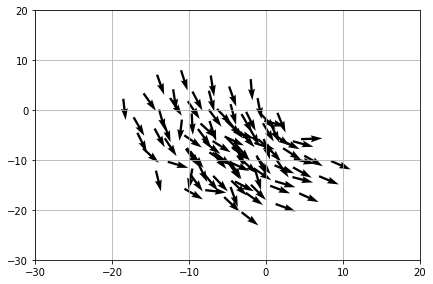

In [109]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 15,
    global_distance = 1000,
    collisions_coef = 1.,
    sync_coef = 0.5,
    clustering_coef = 0.,
    global_coef = 0.25,
    prev_coef = 2.5,
    to_zero_coef = 0.5,
    time_rate = 0.6,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v22.gif', fps=7)



  0%|                                                  | 0/200 [00:00<?, ?it/s]

  2%|▊                                         | 4/200 [00:00<00:05, 32.96it/s]

  4%|█▋                                        | 8/200 [00:00<00:05, 34.48it/s]

  6%|██▍                                      | 12/200 [00:00<00:05, 34.99it/s]

  8%|███                                      | 15/200 [00:00<00:05, 32.86it/s]

 10%|███▉                                     | 19/200 [00:00<00:05, 31.89it/s]

 12%|████▋                                    | 23/200 [00:00<00:05, 32.49it/s]

 14%|█████▌                                   | 27/200 [00:00<00:05, 33.08it/s]

 16%|██████▎                                  | 31/200 [00:00<00:05, 32.93it/s]

 18%|███████▏                                 | 35/200 [00:01<00:05, 31.62it/s]

 20%|███████▉                                 | 39/200 [00:01<00:05, 31.16it/s]

 22%|████████▊                                | 43/200 [00:01<00:05, 30.82it/s]

 24%|█████████▊           

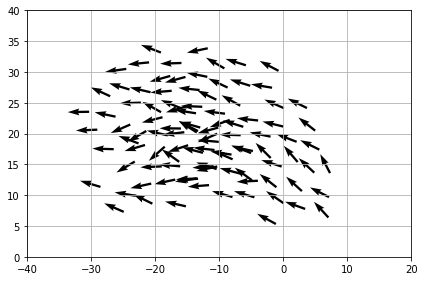

In [110]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 15,
    global_distance = 1000,
    collisions_coef = 1.,
    sync_coef = 0.5,
    clustering_coef = 0.,
    global_coef = 0.25,
    prev_coef = 2.5,
    to_zero_coef = 0.2,
    time_rate = 0.6,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v23.gif', fps=7)



  0%|                                                  | 0/200 [00:00<?, ?it/s]

  2%|▊                                         | 4/200 [00:00<00:05, 38.41it/s]

  4%|█▋                                        | 8/200 [00:00<00:05, 35.70it/s]

  6%|██▍                                      | 12/200 [00:00<00:05, 34.89it/s]

  8%|███▎                                     | 16/200 [00:00<00:05, 35.89it/s]

 10%|████                                     | 20/200 [00:00<00:05, 34.25it/s]

 12%|████▉                                    | 24/200 [00:00<00:05, 34.69it/s]

 14%|█████▋                                   | 28/200 [00:00<00:05, 34.31it/s]

 16%|██████▌                                  | 32/200 [00:00<00:05, 31.87it/s]

 18%|███████▍                                 | 36/200 [00:01<00:04, 33.34it/s]

 20%|████████▏                                | 40/200 [00:01<00:04, 34.71it/s]

 22%|█████████                                | 44/200 [00:01<00:05, 30.17it/s]

 24%|█████████▊           

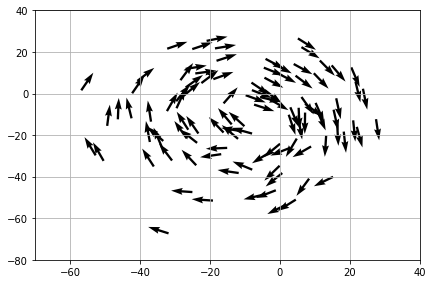

In [111]:
max_iters = 200
init_params = dict(N=100, d=2)
update_params = dict(
    collisions_distance = 3,
    sync_distance = 7,
    clustering_distance = 15,
    global_distance = 1000,
    collisions_coef = 1.,
    sync_coef = 0.5,
    clustering_coef = -0.3,
    global_coef = 0.25,
    prev_coef = 2.5,
    to_zero_coef = 0.2,
    time_rate = 0.6,
)
update_velocities = update_velocities_boid
state, log = run_system(init_params, update_params, init_state, update_state,
    calc_logs, max_iters)
plot_dynamics(log, './gifs/new-local-dynamics-v24.gif', fps=7)